## Motivation

Hi there,

I have been working on this Kaggle for the last couple of weeks and I must say it's a blast. Data is huge, making possibilities endless.

At my current job I have dealt with wifi and plan data before, working with shopping malls for different use cases.
One thing that really mattered to us was to build a solid plan, as something we could request from, that would give us more insights about the positions.

As you may have figured it out most paths only happen in the corridor, and never in the shops. Mainly cause wifi signals in shops are way less precise, and also cause shopping mall "Access Points fields" usually stop at the shops' door. They normally only populate the corridors with them.

With that observation done, one could like to extract the geometry of the corridor in order to have a field of possible positions, rather that considering an infinite R2 space.
That's what I have been working on in the last few days.

**I translated the geojson from the raw data to match the plan images and thus to match the waypoints positions.**
I also substracted the shop geometries from the floor layout geometries so that only the corridor geometry is kept, making it easier to work with.

I have published the dataset: https://www.kaggle.com/rafaelcartenet/indoor-location-navigation-scaled-geojson

It contains for each floor of the 204 sites, the translated geometry as **shapely Polygons (or MultiPolygons)**. (https://shapely.readthedocs.io/en/stable/manual.html#polygons)

Hope it is easy for y'all to work with!

I might also add the translated geojson, if that helps some of you.

I also made an hello world notebook to use the dataset for few use cases: https://www.kaggle.com/rafaelcartenet/how-to-use
It includes:
- Determine whether a point (x, y) belongs to the corridor geometry
- Find the closest point to the corridor
- Discretize corridor

Below are the explanations of how I did it, the source code, as well as an example.



Below is an example of the result, where the geometry has been ploted over the image of one floor plan, you can tell the geometry matches the corridor layout and excludes the inside shops.

Result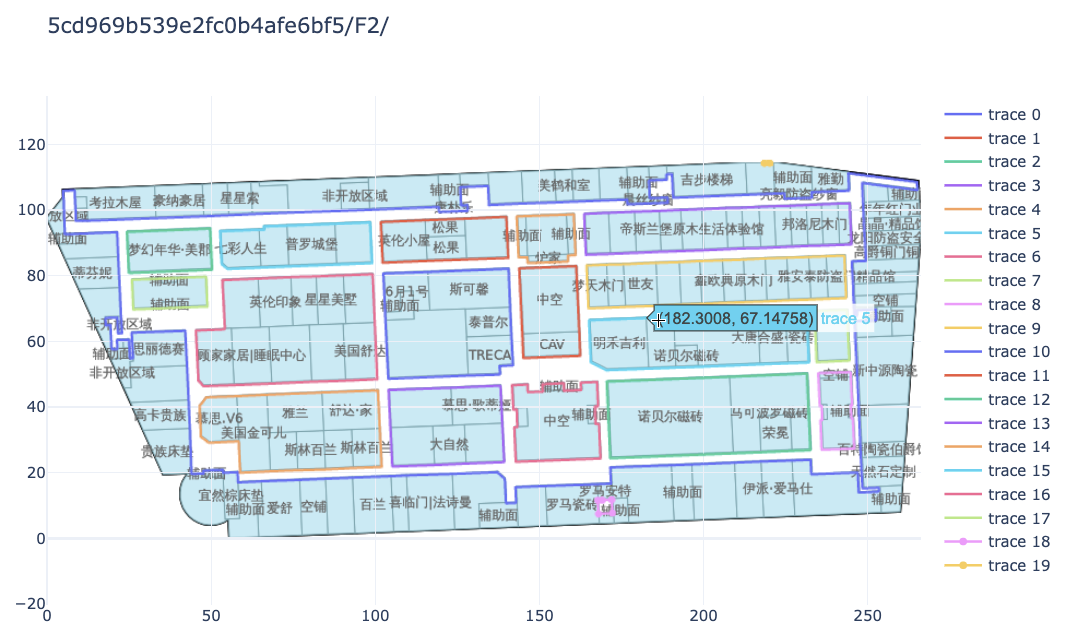

## Technique

The idea is rather simple. We have a geojson with its own referential (latitude longitude) and an image with its own referential (pixels).
By picking a set of points from the two sources, we can find the translation (affine transformation) from one referential to the other.
The easiest points to extract from both the image and the geojson are the bounding box points.
The key point here that allows us to do that is that the angle of both sources is the same. Meaning there is no rotation in our transformation, meaning the bounding box will represent the exact same points on the two sources.

Geojson bounding box extraction (Super easy):
- Extract x_min, y_min, x_max, y_max from all possible coordinates.
- That's it

Image bouding box extraction (bit more tricky):
- Transform image to gray scale (making sure we keep allt he image details)
- Only keep dark enough pixes using a threshold, making sure we only keep different than white pixels
- Extract coordinates of the non null pixels
- Extract x_min, y_min, x_max, y_max from all possible coordinates.

In both cases I have been first using the convex hull of the extracted coordinates, in order to extract from both sources a more stable object, as I thought.
I realised later than the bouding box of a set of coordinates is actually the same bouding box of the convex hull of these same coordinates, making it potentially uselss. I even though kept it.

Provided geojsons are actually well formatted. Each contains features, and the first feature is always the global layout of the floor. The remaining ones are the shops (or else) represented as blue polygons on the images.
It is thus pretty easy to do the difference between the floor layout and all the shops to keep only the corridor geometry.

Once I fitted the translation between my sets of points it is pretty straight forward to translate my corridor geometry.

In [ ]:
!pip install Pillow
!pip install nudged

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import copy
from shapely.geometry import shape, GeometryCollection, Polygon, MultiPolygon
from shapely.affinity import affine_transform
from PIL import Image, ImageOps
import nudged
import numpy as np
from skimage.morphology import convex_hull_image
import matplotlib.pyplot as plt
import json
import plotly.graph_objs as go
import glob
import random

You can pick random floor for testing purposes

In [ ]:
geojson_files = glob.glob('/kaggle/**/geojson_map.json', recursive=True)
geojson_file = random.choice(geojson_files)
geojson_file

site, floor = geojson_file.split('/')[5:7]

In [ ]:
site = '5cd56be4e2acfd2d33b66d0e'
floor = '2F'

Files loading

In [ ]:
geojson_file = '/kaggle/input/indoor-location-navigation/metadata/%s/%s/geojson_map.json' % (site, floor)
infos_file ='/kaggle/input/indoor-location-navigation/metadata/%s/%s/floor_info.json' % (site, floor)
image_file ='/kaggle/input/indoor-location-navigation/metadata/%s/%s/floor_image.png' % (site, floor)

image = Image.open(image_file)

with open(infos_file, 'rb') as f:
    infos = json.load(f)
    
with open(geojson_file, 'rb') as f:
    geojson = json.load(f)

In [ ]:
image

In [ ]:
def extract_coords_from_polygon(polygon):
    coords = []
    if type(polygon) == MultiPolygon:
        polygons = polygon.geoms
    else:
        polygons = [polygon]

    for polygon in polygons:
        x, y = polygon.exterior.xy
        coords.append((np.array(x), np.array(y)))
        for interior in polygon.interiors:
            x, y = interior.xy
            coords.append((np.array(x), np.array(y)))

    return coords


def get_bounding_box(x, y):
    x_min = min(x)
    y_min = min(y)
    x_max = max(x)
    y_max = max(y)
    return np.array([
        [x_min, y_min],
        [x_min, y_max],
        [x_max, y_min],
        [x_max, y_max]
    ])


def plot_shape(shapes):
    if type(shapes) == Polygon:
        shapes = [shapes]
    for shape in shapes:
        for interior in shape.interiors:
            plt.plot(*interior.xy)
        plt.plot(*shape.exterior.xy)


def extract_geometries(geojson):
    # Extract floor plan geometry (First geometry)
    floor = copy.deepcopy(geojson)
    floor['features'] = [floor['features'][0]]
    floor_layout = GeometryCollection([shape(feature["geometry"]).buffer(0) for feature in floor['features']])[0]

    # Extract shops geometry (remaining ones)
    shops = copy.deepcopy(geojson)
    shops['features'] = shops['features'][1:]
    shops_geometry = GeometryCollection([shape(feature["geometry"]).buffer(0.1) for feature in shops['features']])

    # Geometry differences to get corridor (floor layout - shops)
    corridor = copy.deepcopy(floor_layout)
    for shop in shops_geometry:
        corridor = corridor.difference(shop)

    return floor_layout, corridor


def extract_image_bounding_box(image):
    # Flip and convert to black and white
    gray_image = ImageOps.flip(image).convert('LA')
    bw_image = np.array(gray_image.point(lambda p: p > 251 and 255)) > 0
    bw_image = Image.fromarray(bw_image.any(axis=2) == True)

    # Get convex hull
    ch_image = convex_hull_image(np.array(bw_image))

    # Transform to coordinates
    image_y, image_x = np.where(ch_image == True)

    bounding_box = get_bounding_box(image_x, image_y)
    return bounding_box


def extract_geojson_bounding_box(floor_layout):
    # Get convex hull
    ch_geojson = floor_layout.convex_hull

    coords = [coord for coord in ch_geojson.exterior.coords]
    geojson_x = [coord[0] for coord in coords]
    geojson_y = [coord[1] for coord in coords]

    bounding_box = get_bounding_box(geojson_x, geojson_y)
    return bounding_box


def find_translation(points_a, points_b):
    """
    Find best translation between 2 sets of points
    Map right coefficients for:
    https://shapely.readthedocs.io/en/stable/manual.html#shapely.affinity.affine_transform
    """
    trans = nudged.estimate(points_a, points_b)
    matrix_cooefs = np.ravel(trans.get_matrix())

    trans_coeffs = [
        matrix_cooefs[0],
        matrix_cooefs[1],
        matrix_cooefs[3],
        matrix_cooefs[4],
        matrix_cooefs[2],
        matrix_cooefs[5],
    ]

    return trans_coeffs


def geo_referencing(image, geojson, info):
    """
    :param image: raw PIL image object
    :param geojson: dict, geojson format
    :param info: dict, plan infos
    """
    # Extract floor layout and corridor geometries from geojson (shapely Polygon/MultiPolygon)
    floor_layout, corridor = extract_geometries(geojson)

    # Extract bounding boxes both from image and geojson (Using convexhull)
    image_bounding_box = extract_image_bounding_box(image)
    geojson_bounding_box = extract_geojson_bounding_box(floor_layout)

    # Find best translation from geojson to image referential
    translation_coeffs = find_translation(geojson_bounding_box, image_bounding_box)

    # Convert to image size scale
    translated_corridor = affine_transform(corridor, translation_coeffs)

    # Convert to waypoints scale (using ratio between waypoint scale and image scale)
    x_ratio = info["map_info"]["width"] / image.size[0]
    y_ratio = info["map_info"]["height"] / image.size[1]
    waypoint_translation_coeffs = [
        x_ratio, 0, 0,
        y_ratio, 0, 0
    ]
    translated_corridor = affine_transform(translated_corridor, waypoint_translation_coeffs)

    return translated_corridor

In [ ]:
geometry = geo_referencing(image, geojson, infos)
plot_shape(geometry)

In [ ]:
fig = go.Figure()

fig.update_layout(
    images=[
        go.layout.Image(
            source=image,
            xref="x",
            yref="y",
            x=0,
            y=infos["map_info"]["height"],
            sizex=infos["map_info"]["width"],
            sizey=infos["map_info"]["height"],
            sizing="contain",
            opacity=1,
            layer="below",
        )
    ]
)

for coord in extract_coords_from_polygon(geometry):
    x, y = coord
    fig.add_trace(
        go.Scattergl(
            x=x,
            y=y,
        ))

# configure
fig.update_xaxes(autorange=False, range=[0, infos["map_info"]["width"]])
fig.update_yaxes(autorange=False, range=[0, infos["map_info"]["height"]], scaleanchor="x", scaleratio=1)
fig.update_layout(
    title=go.layout.Title(
        text="Site: %s Floor: %s" % (site, floor),
        xref="paper",
        x=0,
    ),
    autosize=True,
    width=900,
    height=200 + 900 * infos["map_info"]["height"] / infos["map_info"]["width"],
    template="plotly_white",
)

fig.show()